### Importing Required Libraries

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

* scikit-learn: We import various tools from scikit-learn for text feature extraction, splitting the data, creating models, and evaluating them.
* imblearn: SMOTE is used to handle class imbalance in the dataset by oversampling the minority class.
* pandas: For data manipulation and loading the dataset.
* numpy: For numerical operations like matrix manipulations.
* re: Used for preprocessing text data by removing unwanted characters.
* matplotlib/seaborn: Used for visualizations.

### Loading the Dataset

In [124]:
data = pd.read_csv("test.tsv", sep='\t')  

### Preprocessing Text Data

In [126]:
# Preprocessing Function
def preprocess_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', text).lower()

# Apply preprocessing
data['title'] = data['title'].apply(preprocess_text)
data['text'] = data['text'].apply(preprocess_text)

* Preprocessing: We define a preprocess_text function to clean the text by: 
* Removing any characters that are not alphabets or whitespace ([^a-zA-Z\s]).
* Converting all text to lowercase to ensure consistency.
* We apply this function to both the title and text columns of the dataset to clean tem
m.


### Feature Engineering

In [129]:
data['title length'] = data['title'].apply(lambda x: len(x.split()))
data['text length'] = data['text'].apply(lambda x: len(x.split()))

* We add new features, title length and text length, which are the number of words in the title and text columns, respectively.* 	These features can help the model understand the relationship between the length of text and classification


### Encoding the 'subject' Column

In [132]:
label_encoder = LabelEncoder()
data['subject'] = label_encoder.fit_transform(data['subject'])

* The subject column is categorical, so we use Label Encoding to convert it into numerical values.* 	LabelEncoder transforms each unique value in the subject column into an integer.


### Splitting the Data into Training and Testing Sets

In [135]:
X = data[['title', 'text', 'subject', 'title length', 'text length']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* We split the dataset into features (X) and target (y).  
* X contains the title, text, subject, title length, and text length columns.
* y contains the target labels (label).
* We use train_test_split() to split the data into training and testing sets, with 20% allocated for testig.
ng.g.


### Vectorizing Text Features

In [138]:
title_vectorizer = TfidfVectorizer(max_features=5000)
text_vectorizer = TfidfVectorizer(max_features=5000)

title_features = title_vectorizer.fit_transform(X_train['title']).toarray()
text_features = text_vectorizer.fit_transform(X_train['text']).toarray()

*	We use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the text data into numerical vectors.
* max_features=5000 limits the features to the top 5000 words based on their importance.
*	title_features and text_features represent the vectorized version of the title and text columns in the training set.


### Combining All Features

In [141]:
numeric_features = X_train[['subject', 'title length', 'text length']].values
X_train_combined = np.hstack((title_features, text_features, numeric_features))

* We combine the vectorized text features (from the title and text) with the numerical features (subject, title length, text length).
* np.hstack() is used to horizontally stack the arrays together to form a single feature set for training.


### Visualizing Class Distribution Before SMOTE

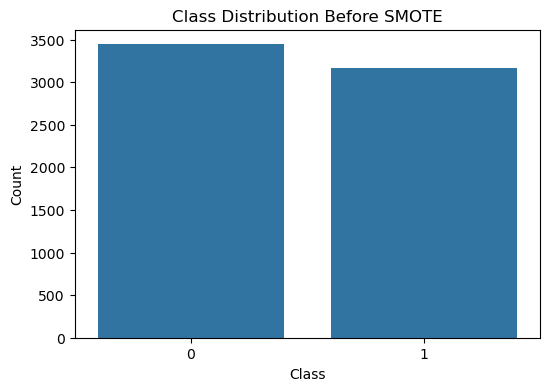

In [144]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Applying SMOTE to Handle Class Imbalance

In [146]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

* SMOTE is used to balance the class distribution by generating synthetic samples for the minority class.
* This helps prevent the model from being biased towards the majority class.

### Visualizing Class Distribution After SMOTE

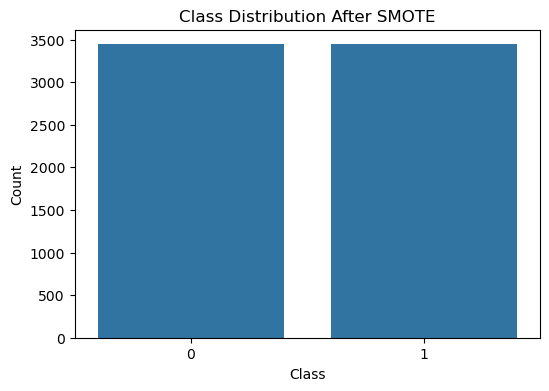

In [149]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Processing Test Data

In [151]:
title_features_test = title_vectorizer.transform(X_test['title']).toarray()
text_features_test = text_vectorizer.transform(X_test['text']).toarray()
numeric_features_test = X_test[['subject', 'title length', 'text length']].values
X_test_combined = np.hstack((title_features_test, text_features_test, numeric_features_test))

* We apply the same preprocessing (vectorization) to the test data.
* The test data is vectorized using the same TfidfVectorizer objects, ensuring consistency between training and testing data.


### Training the Random Forest Model

In [154]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

* We initialize and train a Random Forest Classifier using the resampled training data (after SMOTE).
* The model learns to classify based on the features provided.


### Evaluating the Model

In [157]:
y_pred = model.predict(X_test_combined)
y_pred_proba = model.predict_proba(X_test_combined)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC:", roc_auc)

Accuracy: 0.9969770253929867
Precision: 0.9963144963144963
Recall: 0.997539975399754
F1 Score: 0.9969268592501537
AUC-ROC: 0.9999100526082549


* We evaluate the model on the test set using several metrics: 
* **Accuracy**: Proportion of correctly classified samples.
* **Precision**: Ratio of true positives to all predicted positives.
* **Recall**: Ratio of true positives to all actual positives.
* **F1** **Score**: Harmonic mean of precision and recall.
* **AUC-ROC**: Area under the receiver operating characteristic curve.rve.


### Plotting Confusion Matrix

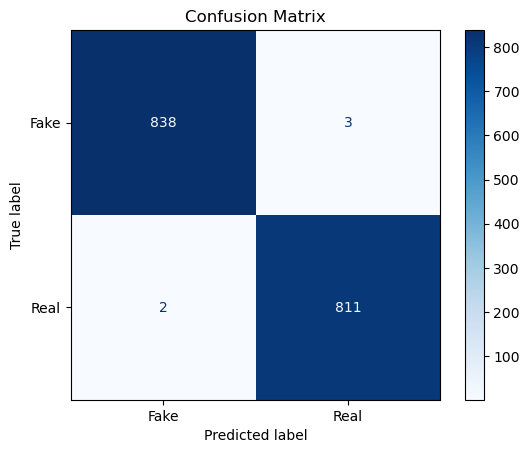

In [160]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
cmd.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

* We plot the Confusion Matrix to visually represent the number of true positives, false positives, true negatives, and false negatives.* 	This helps us assess the performance of the model on each class.


### Plotting ROC Curve

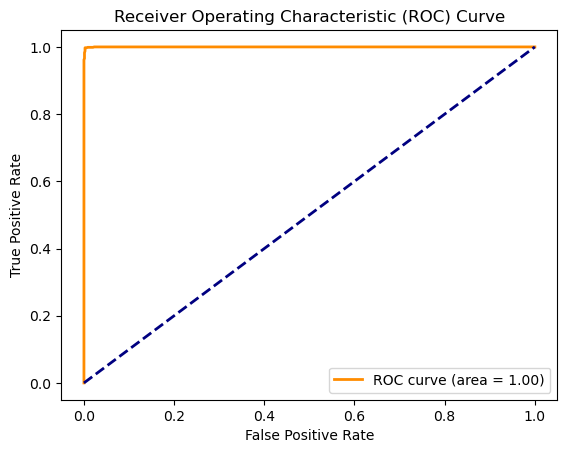

In [163]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

* The ROC Curve shows the trade-off between the true positive rate and false positive rate at various thresholds.* 	The AUC (Area Under the Curve) gives us a measure of the model's ability to distinguish between classes.


### Plotting Precision-Recall Curve

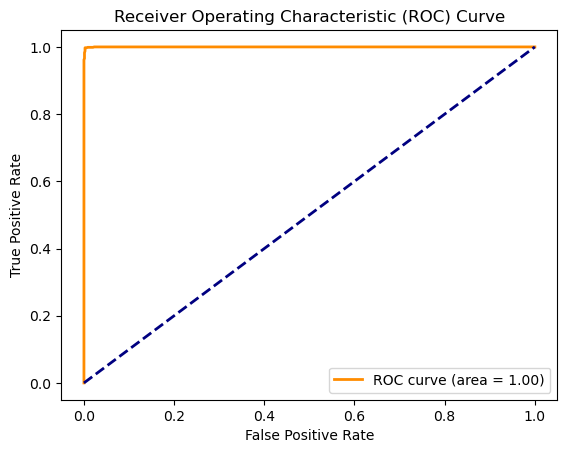

In [166]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The Precision-Recall Curve provides another way to evaluate the performance of the model, particularly when dealing with imbalanced datasets.

### Feature Importance Analysis

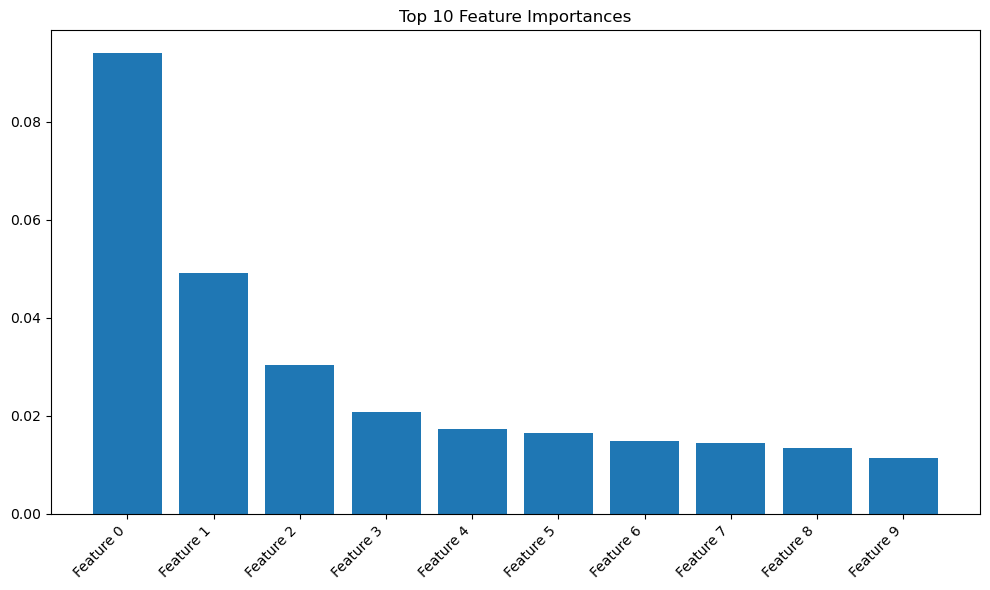

In [169]:
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), feature_importances[indices[:10]], align="center")
plt.xticks(range(10), [f"Feature {i}" for i in range(10)], rotation=45, ha='right')
plt.tight_layout()
plt.show()

* Feature Importance gives insight into which features are most influential in making predictions.* 	We plot the top 10 most important features


In [171]:
result_list = []

for title, prediction in zip(X_test['title'], y_pred):
    result_list.append(f'["{title}", {prediction}]')

output = '{\n' + ',\n'.join(result_list) + '\n}'

# Save to result.txt file
with open("result.txt", "w") as file:
    file.write(output)

print("Results saved to result.txt")

Results saved to result.txt
